# Data Lab 4

Predicting climate 3-month averages (precipitation, near-surface temperature) from the ENSO state

In [146]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Indonesia precipitation example

Predicting JJA Indonesia precipitation from ENSO state.

The conditional distribution aka "forecast distribution" 

$$ p(y | x) $$

- $y$ is Indonesia precipitation
- $x$ 
    - categorical: cool, neutral, warm Nino 3.4 based on terciles
    - Nino 3.4 value

Forecast formats
- single number
- Prediction interval
- Prob. of above, middle, below rainfall categories

Training data: 1979 - 2019

Test data: 2020


## 1. Read data

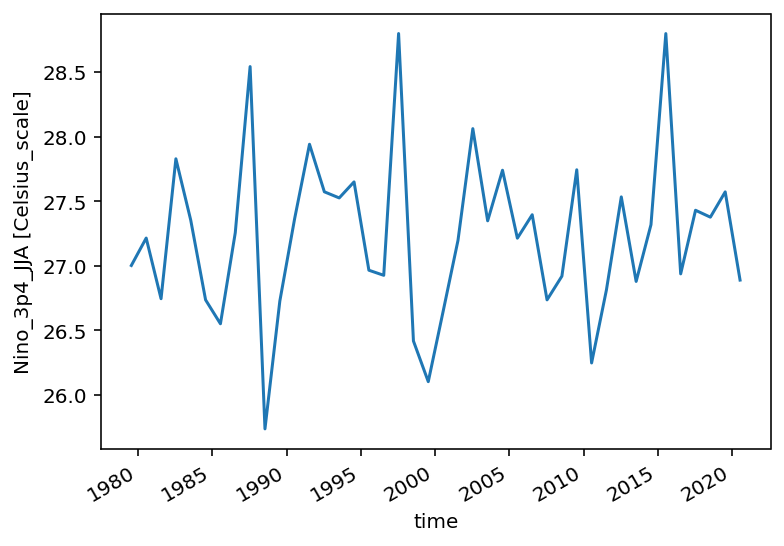

In [147]:
# Read JJA Nino 3.4
n34_JJA_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_JJA/dods'
n34_JJA_ds = xr.open_dataset(n34_JJA_url)
n34_JJA = n34_JJA_ds.n34_JJA
n34_JJA.plot();

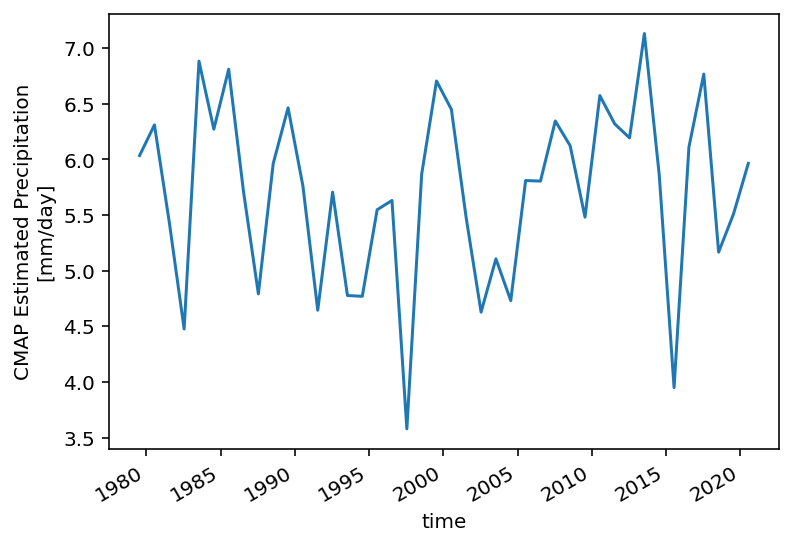

In [148]:
# Read Indonesia region rainfall
indo_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.indonesia_prcp_JJA/dods'
indo_ds = xr.open_dataset(indo_url)
prcp_indo = indo_ds.indonesia_prcp_JJA
prcp_indo.plot();

### 1.1 Withhold the final value (this year)

In [149]:
# Develop our prediction on all the values up to this year and then predict this year's value from xp
x = n34_JJA[0:-1].values
xp = n34_JJA[-1].values # this year
y = indo_ds.indonesia_prcp_JJA[:-1].values
yp = indo_ds.indonesia_prcp_JJA[-1].values

### 1.2 Define Nino 3.4 and precipitation terciles

In [150]:
# Define warm and cool ENSO categories
xm = x.mean()
xa = x - xm

thresholds = np.quantile(xa, np.array([1./3., 2./3.]))
t_nina = xa <= thresholds[0]
t_nino = xa >= thresholds[1]
t_neut = ~(t_nina | t_nino)

y_thresholds = np.quantile(y, np.array([1./3., 2./3.]))

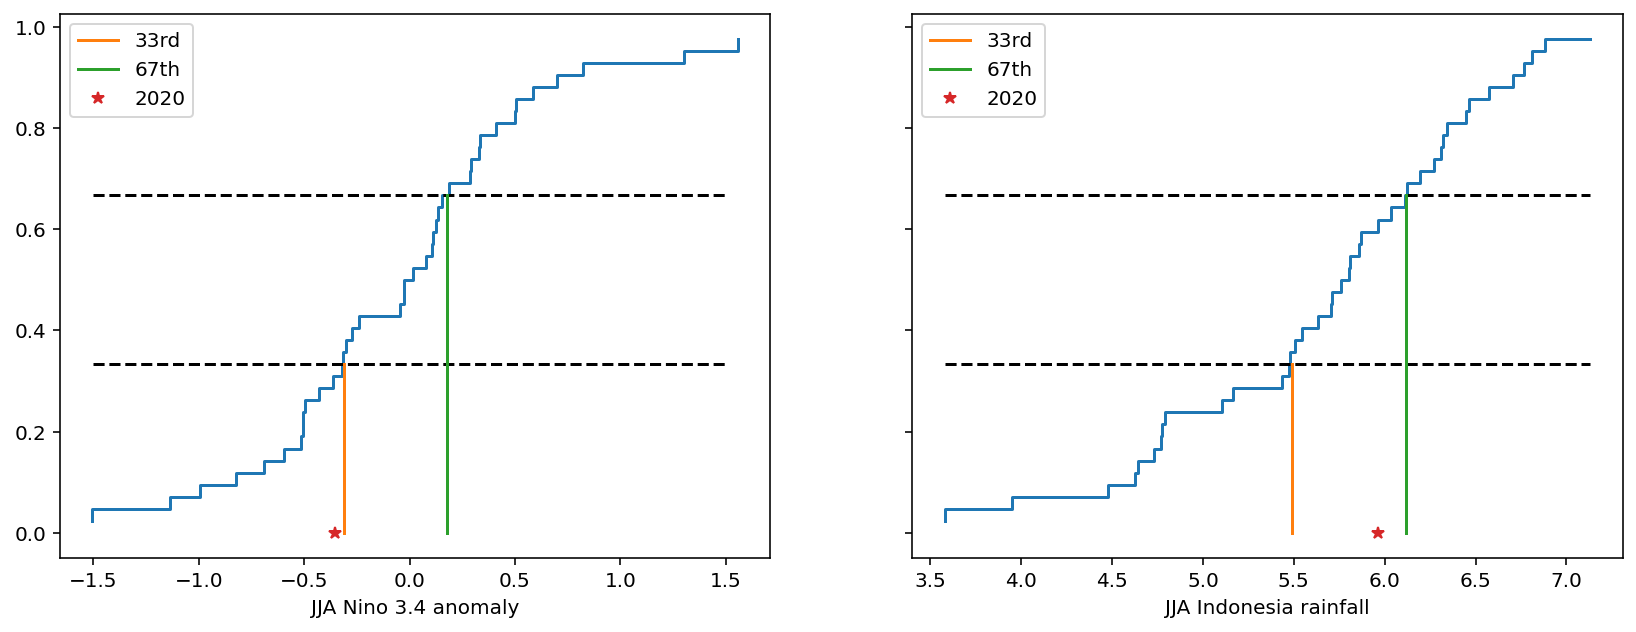

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax = axs[0]
ax.step(np.sort(xa), np.arange(1,41 + 1)/(41 + 1))
ax.plot(np.array([-1.5,1.5]), 1./3.*np.array([1,1]), 'k--')
ax.plot(np.array([-1.5,1.5]), 2./3.*np.array([1,1]), 'k--')
ax.plot(thresholds[0]*np.array([1, 1]), np.array([0, 1./3.]), label = '33rd')
ax.plot(thresholds[1]*np.array([1, 1]), np.array([0, 2./3.]), label = '67th')
ax.plot(xp - xm, 0, '*', label = '2020')
ax.set_xlabel('JJA Nino 3.4 anomaly');
ax.legend()

ax = axs[1]
ax.step(np.sort(y), np.arange(1,41 + 1)/(41 + 1))
x_range = np.array([y.min(),y.max()])
ax.plot(x_range, 1./3.*np.array([1,1]), 'k--')
ax.plot(x_range, 2./3.*np.array([1,1]), 'k--')
ax.plot(y_thresholds[0]*np.array([1, 1]), np.array([0, 1./3.]), label = '33rd')
ax.plot(y_thresholds[1]*np.array([1, 1]), np.array([0, 2./3.]), label = '67th')
ax.plot(yp, 0, '*', label = '2020')
ax.set_xlabel('JJA Indonesia rainfall');
ax.legend();

### 1.3 Make forecasts based on the JJA Nino 3.4 category

In [152]:
# Point estimate
y_forecast = np.mean(y[t_nina])
print('Forecast total = {:4.2f} mm/day'.format(y_forecast))
print('Forecast anomaly = {:4.2f} mm/day'.format(y_forecast - y.mean()))

Forecast total = 6.29 mm/day
Forecast anomaly = 0.59 mm/day


In [153]:
# Prediction interval
pi_80 = np.quantile(y[t_nina], [0.10, 0.90])
print('80% of the time during La Nina, JJA rainfall totals have been in the range', pi_80)
print('80% of the time during La Nina, JJA rainfall anomalies have been in the range', pi_80 - y.mean())

80% of the time during La Nina, JJA rainfall totals have been in the range [5.70192914 6.77854986]
80% of the time during La Nina, JJA rainfall anomalies have been in the range [0.00279527 1.07941599]


In [154]:
# Probability forecasts
P_above = np.mean( y[t_nina] > y_thresholds[1])
P_below = np.mean( y[t_nina] < y_thresholds[0])

print('Probability of prcp in the above category {:.1f}%'.format(100*P_above))
print('Probability of prcp in the neutral category {:.1f}%'.format(100*(1 - P_above - P_below)))
print('Probability of prcp in the below category {:.1f}%'.format(100*P_below))

Probability of prcp in the above category 71.4%
Probability of prcp in the neutral category 21.4%
Probability of prcp in the below category 7.1%


### 2. $K$-nearest neighbors: Predict rainfall based on the *value* of JJA Nino 3.4.

We cannot sample from $p(y|x)$ because

In [155]:
np.sum(x == xp)

0

But we can sample from $p(y|X \text{ is close to } x)$. We'd have to define close and that might depend on the value of $x$.

Alternatively we can use the $K$ data closest to $x$. What value should we choose for $K$? Not too big and not too small. $K=10$?

In [156]:
K = 10
knn = np.argsort( (x - xp)**2)
knn = knn[:K]

### 2.1 Make forecasts 

In [157]:
# Point estimate
y_forecast = np.mean(y[knn])
print('Forecast total = {:4.2f} mm/day'.format(y_forecast))
print('Forecast anomaly = {:4.2f} mm/day'.format(y_forecast - y.mean()))

Forecast total = 6.09 mm/day
Forecast anomaly = 0.40 mm/day


In [158]:
# Prediction interval
pi_80 = np.quantile(y[knn], [0.10, 0.90])
print('80% of the JJA rainfall totals were in the range', pi_80)
print('80% of the JJA rainfall anomalies were in the range', pi_80 - y.mean())

80% of the JJA rainfall totals were in the range [5.53616681 6.42385831]
80% of the JJA rainfall anomalies were in the range [-0.16296706  0.72472444]


In [159]:
# Probability forecasts
P_above = np.mean( y[knn] > y_thresholds[1])
P_below = np.mean( y[knn] < y_thresholds[0])

print('Probability of prcp in the above category {:4.1f}%'.format(100*P_above))
print('Probability of prcp in the neutral category {:4.1f}%'.format(100*(1 - P_above - P_below)))
print('Probability of prcp in the below category {:4.1f}%'.format(100*P_below))

Probability of prcp in the above category 50.0%
Probability of prcp in the neutral category 40.0%
Probability of prcp in the below category 10.0%


Need an objective way of choosing $K$. Cross-validation is one approach. https://en.wikipedia.org/wiki/Cross-validation_(statistics)

KNN is based on $E[y|x]$ being a constant in a neighborhood of $x$.

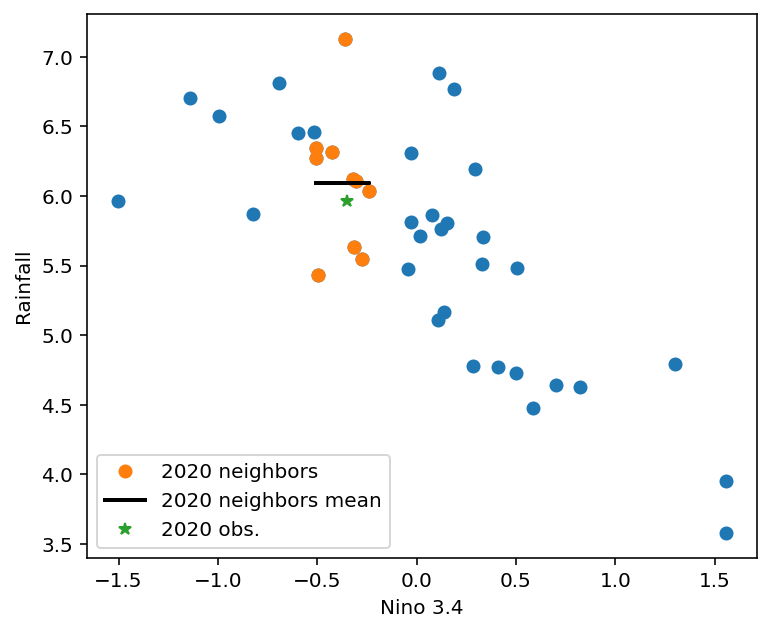

In [160]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

ax.plot(xa[knn], y[knn],'o', label='2020 neighbors')
ax.plot(xa[knn], y[knn].mean() + np.zeros_like(y[knn]), 'k', linewidth=2, label='2020 neighbors mean')
ax.plot(xp - xm, yp, '*', label = '2020 obs.')

ax.legend();

### 3. Linear regression: Predict rainfall based on the *value* of JJA Nino 3.4.

Linear regression takes $ E[ y | x ]$ to be a linear function of $x$ everywhere:

$$ E(\text{rainfall } | \text{ Nino 3.4} = x ) = ax + b $$

Estimate $a$ and $b$ by least squares. Make a forecast (single number)

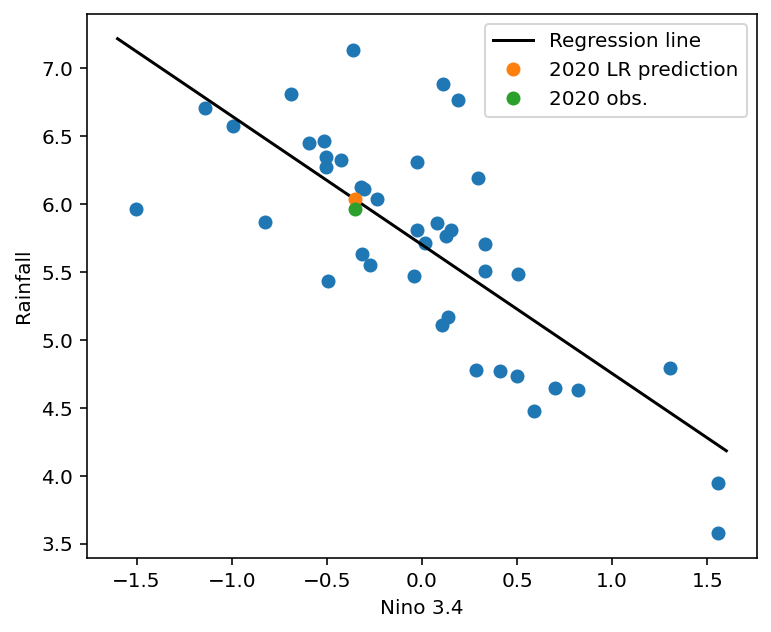

In [161]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,0] = xa #<-------------------------------------------compare to below
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp -xm) + beta[1] 

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[0]*x_line + beta[1], 'k', label = 'Regression line');
ax.plot(xp - xm, y_forecast_LR, 'o', label = '2020 LR prediction')
ax.plot(xp - xm, yp, 'o', label = '2020 obs.')

ax.legend();

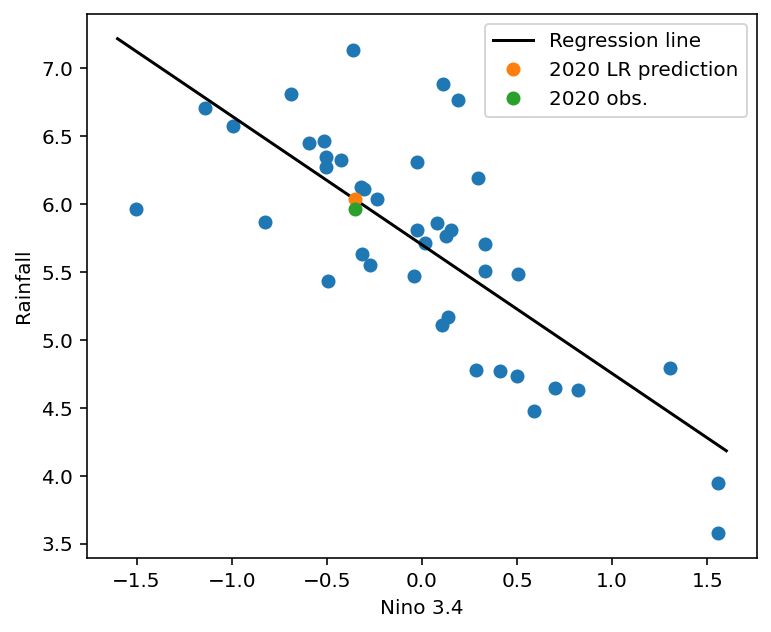

In [162]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,0] = x #<-------------------------------------------compare to above
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp) + beta[1] 

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[0]*(x_line + xm) + beta[1], 'k', label = 'Regression line');
ax.plot(xp - xm, y_forecast_LR, 'o', label = '2020 LR prediction')
ax.plot(xp - xm, yp, 'o', label = '2020 obs.')

ax.legend();

## Exercises

1. (10 points) Show that the function $g(x)$ that minimizes $E[ (Y - g(x))^2 | X = x]$ is $g(x) = E[Y | X=x]$.  
HINT: As a warm-up, first show that the constand $c$ that minimizes $E[(y-c)^2]$ is $c = E[y]$ without using calculus.  
Look at the terms that come out of $E[(y-\mu_Y + \mu_Y - c)^2]$.

Well, $E[(y-c)^2] = \sum_{}^{y} (y^2 - 2cy + c^2)(p(y)) = \sum_{}^{y} (y*yp(y) - 2cyp(y) + c^2)$
If we make c into the expected value of y here, then 
$= \sum_{}^{y} (y * E[y] - 2 * E[y]^2 + E[y]^2) = E[y] * \sum_{}^{y} (y - 2E[y] + E[y]) = E[y] * \sum_{}^{y} (y - E[y])$
Which minimizes the function

This can be extended to $E[ (Y - g(x))^2 | X = x]$ being minimized by $g(x) = E[Y | X=x]$ because the conditional distribution of $Y|x$ behaves like a random variable, just based on $X=x$

2. (10 points) Suppose that $\hat{\mu}_{Y|x}$ is the average of $N$ independent samples from $p(y|x)$.  
Show that $E[ Y - \hat{\mu}_{Y|x} | X = x] = 0$ and that
$$ E[ (Y - \hat{\mu}_{Y|x})^2 | X = x] = \sigma_{Y|x}^2 \left(1 + \frac{1}{N} \right) \,.$$  
HINT What is the variance of the sample mean?
Forecast error is due to randomness and error in the estimate of the conditional mean.

$E[ Y - \hat{\mu}_{Y|x} | X = x] = \sum_{}^{y} (yp(y) - \hat{\mu}_{Y|x}*p(y)) = \hat{\mu}_{Y|x} - \hat{\mu}_{Y|x} = 0$
$\\$
Essentially, $E[ Y | X = x]$ is $\hat{\mu}_{Y|x}$ by definition. $$\\$$
As for the second part, when you expand the square, the result is 
$$E[((Y|X=x)^2 - 2Y \mu_{Y|x} + \mu_{Y|x}^2)|X=x]$$ \
$$ = E[Y^2|X] - E[Y|X]^2 + E[\mu_{Y|x}^2|x] - E[\mu_{Y|x}]^2$$ \
Which looks like variance of Y plus some other thing that looks like the variance of the sample mean \
Which becomes $$\sigma_{Y|x}^2 + \frac{\sigma_{Y|x}^2}{N}$$

3. (10 points) Compute a 95% confidence interval for the mean of JJA Indonesian rainfall during cool and warm conditions 1979-2019. 
(Reminder how here https://en.wikipedia.org/wiki/Student%27s_t-distribution#How_Student's_distribution_arises_from_sampling)
Add it to the code below to produce the figure. 
<div>
<img src="images/Indonesia_JJA_rainfall_Nino3p4.png" width="600"/>
</div>

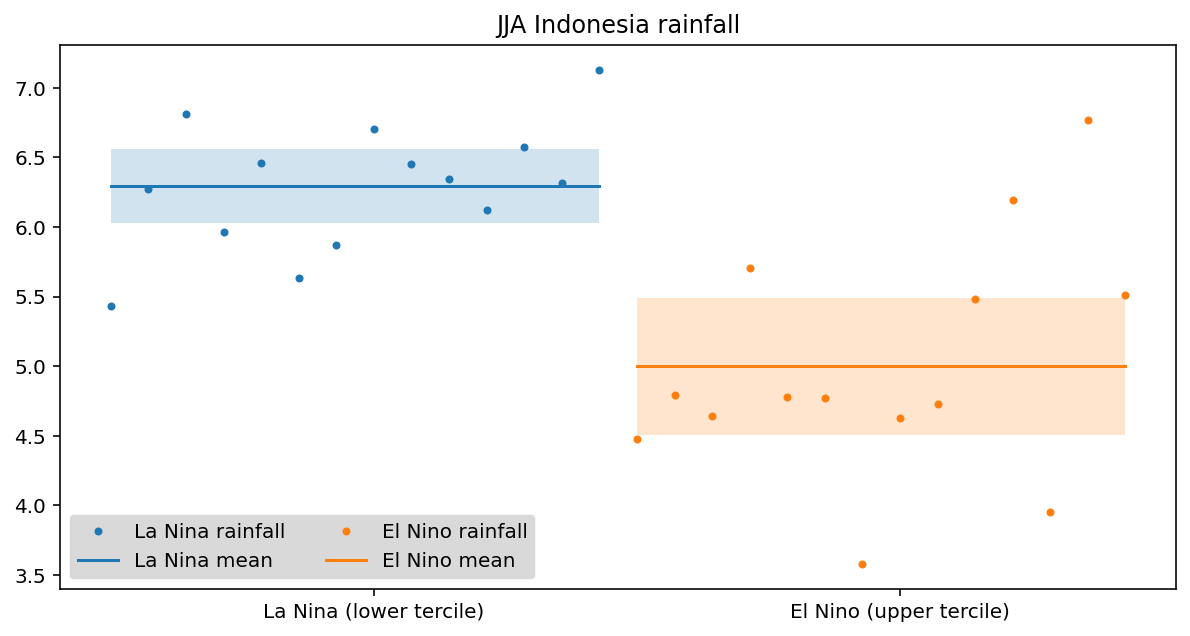

In [163]:
ci = np.nan

N1 = np.count_nonzero(t_nina)
N2 = np.count_nonzero(t_nino)

s1 = np.arange(0,N1)
s2 = np.arange(0,N2)

fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(s1, y[t_nina], '.', label = 'La Nina rainfall')
ax.plot(s1, y[t_nina].mean() + 0.0*s1, color=colors[0], label = 'La Nina mean')
cii = stats.t.interval(0.95, N1-1, loc=np.mean(y[t_nina]), scale=stats.sem(y[t_nina]))
cii = (cii[1]-cii[0])/2
ax.fill_between(s1, y[t_nina].mean() - cii + 0.0*s1, y[t_nina].mean() + cii + 0.0*s1, alpha = 0.2)
#ax.fill_between(s1, cii[0], cii[1], alpha = 0.2)

ax.plot(s2 + N1, y[t_nino], '.', label = 'El Nino rainfall')
ax.plot(s2 + N1, y[t_nino].mean() + 0.0*s2, color=colors[1], label = 'El Nino mean')
ci = stats.t.interval(0.95, N2-1, loc=np.mean(y[t_nino]), scale=stats.sem(y[t_nino]))
ci = (ci[1] - ci[0])/2
ax.fill_between(s2 + N1, y[t_nino].mean() - ci + 0.0*s2, y[t_nino].mean() + ci + 0.0*s2, alpha = 0.2)
#ax.fill_between(s2 + N1, ci[0], ci[1], alpha = 0.2)
ax.set_xticks([])

ax.legend(ncol = 2, framealpha = 0.15, facecolor = 'k', loc = 'lower left');
ax.set_title('JJA Indonesia rainfall');
plt.xticks([N1/2, 3*N2/2],['La Nina (lower tercile)', 'El Nino (upper tercile)']);
# Shading is CI for mean

4. (10 points) Choose $K$ in K-nearest neighbors by finding the value of $K$ whose leave-one-out cross-validated (CV) mean-squared error (MSE) is smallest. Below is starter code.
    - Add comments explaining what the code does. 
    - The 2D array `y_hat` contains forecasts with each column being a different year and each row using a different value of $K$.
    - Compute the error by subtracting $y$. Broadcasting is your friend.
    - Square and average over years to get the mean squared error as function of $K$.  
    - Plot the MSE as a function of $K$.
    
   <div>
   <img src="images/Indonesia_JJA_rainfall_Nino3p4_KNN_CV.png" width="400"/>
   </div>
    
    (The interval is a so-called 1$\sigma$ interval.)  
    MSE = mean(squared error)  
    $\sigma$ = std(squared error)/sqrt(sample size)
    

8

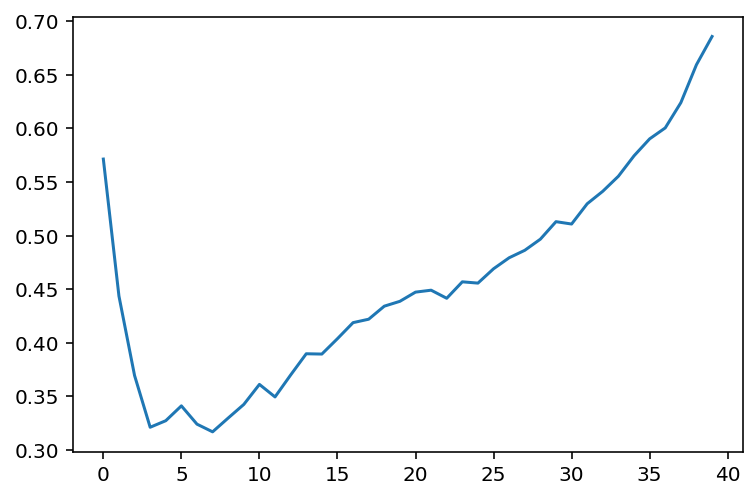

In [164]:
#Upper limit for # of near neighbors
kmax = len(x) - 1

#Create empty matrix
y_hat = np.empty((kmax, len(x)))


for ii in range(0, len(x)):
    leave_1_out = list(range(0, len(x))) #These two lines take one index at a time out of x
    leave_1_out.remove(ii)
    x1 = x[leave_1_out] #Takes all x and y values except the one removed
    y1 = y[leave_1_out]
    knn1 = np.argsort( (x1 - x[ii])**2) #orders nearest values to the removed
    for k in range(1,kmax + 1):
        knn0 = knn1[:k] #knn0 is the k nearest neighbors
        y_hat[k - 1, ii] = y1[knn0].mean() #assigns mean of k nearest neighbors to its respective SPOT in array
errorsSq = (y_hat - y)**2
mseList = np.mean(errorsSq, axis = 1)
plt.plot(mseList)
idealK = 1
smol = 1000
for i in range(len(mseList)):
    if mseList[i] < smol:
        smol = mseList[i]
        idealK = i + 1
idealK

5. (30 points) Look at the Oceanic Nino Index (ONI) values here https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
    - Which winters since 2010 had cool ONI conditions?
    - Find the NOAA winter precipitation outlooks for those years and include them below. Here is the one for the winter of 2017-2018
      <div>
      <img src="https://www.climate.gov/sites/default/files/PrecipitationOutlook_Winter2017_620.png" width="400"/>
      </div>
    - Use the code below to read the Aug Nino 3.4 values from 1979 through 2020.
        - Find the 10 years with Aug Nino 3.4 values closest to that of 2020.
    - Use the code below to read the Dec-Feb (DJF) North America precipitation data for Dec 1979 - Feb 1980 though Dec 2019 - Feb 2020 (last winter). (The time coordinate of the precipitaion is the middle month (Jan) of the 3-month period.)
     - Use KNN with $K=10$ to
         - forecast the DJF precipitation (single map) 
         - Compute an 80% prediction interval (2 maps)
         - Compute the probability of the DJF precipitation being in the below, middle, and above terciles (3 maps)

<!-- Cool Winters since 2010: 2010-2011, 2011-2012, 2016-2017, 2017-2018
![image.png](attachment:2ba3f589-e73c-4e80-a5ba-07fac63e09b3.png)![image.png](attachment:f7659530-4ed3-48be-b668-4b47268286c2.png)
![image.png](attachment:299701a7-46bd-4041-aef7-bb56be38a3c9.png)![image.png](attachment:94dd25a0-f67a-4f24-9b8c-208d8737f53b.png)
![image.png](attachment:d5740655-a6a6-43b6-937c-aff0bc9fcd82.png)![image.png](attachment:8492373b-8cf2-4bea-8ea4-7ea3a952591d.png) -->

Closest years to 2020's August Nino 3.4 values: [1985 2016 1981 1989 2000 1995 2011 2013 2007 1980]


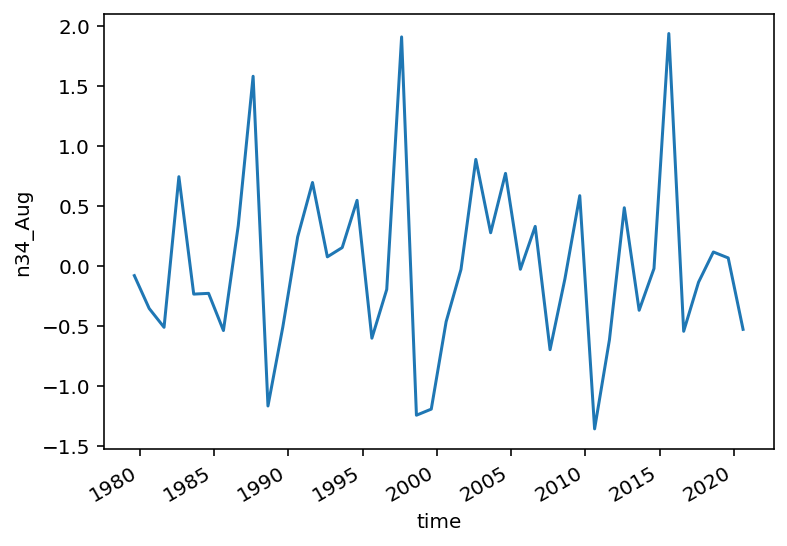

In [165]:
# Aug Nino 3.4 
n34_Aug_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Aug/dods'
n34_Aug_ds = xr.open_dataset(n34_Aug_url)
n34_Aug = n34_Aug_ds.n34_Aug - n34_Aug_ds.n34_Aug.mean('T')
n34_Aug.plot();

no20 = n34_Aug[:-1]
ordered = np.argsort((no20 - n34_Aug[-1])**2)
years = 1979 + ordered[0:10]
print("Closest years to 2020's August Nino 3.4 values: {}".format(years.values))

/opt/conda/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2020 DJF Forecast based on 10 nearest neighbors in Nino 3.4 measure:


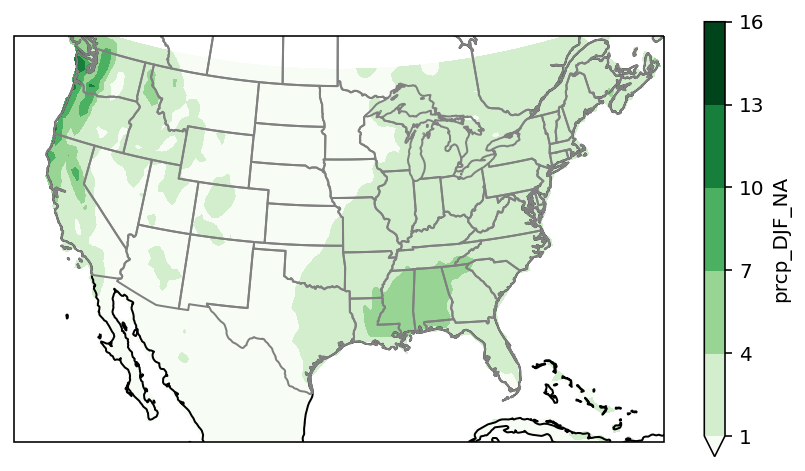

In [166]:
import matplotlib.colors as colors

prcp_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_DJF_NA/124/pop/dods'
prcp_DJF_ds = xr.open_dataset(prcp_DJF_url)
prcp = prcp_DJF_ds.prcp_DJF_NA
prcp.load()

# two-panel plot of the first and last values 
# This is a "fancy" plot showing some additional features
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

picks = ordered[0:10]
closeData = prcp[picks.values]
avgs = np.mean(closeData, axis = 0)


fig = plt.figure(figsize=(16,4))
#ax1 = closeData.mean('T')
ax1 = plt.subplot(1,2,1,projection=proj_map)
#ax2 = plt.subplot(1,2,2,projection=proj_map)

extent = [-120, -70, 20, 50.5]

print("2020 DJF Forecast based on 10 nearest neighbors in Nino 3.4 measure:")

avgs.plot.contourf(transform=proj_dta, ax = ax1, vmin=1, vmax=16, cmap='Greens', levels = 6)
ax1.coastlines();
ax1.add_feature(cfeature.STATES, edgecolor='gray')
ax1.set_extent(extent)

In [167]:
picks = ordered[0:10]
closeData = prcp[picks.values]
avgs = np.mean(closeData, axis = 0)
avgs.plot.contourf(transform = proj_dta, ax = ax1, vmin=1, vmax=16, cmap='Greens', levels = 6)

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


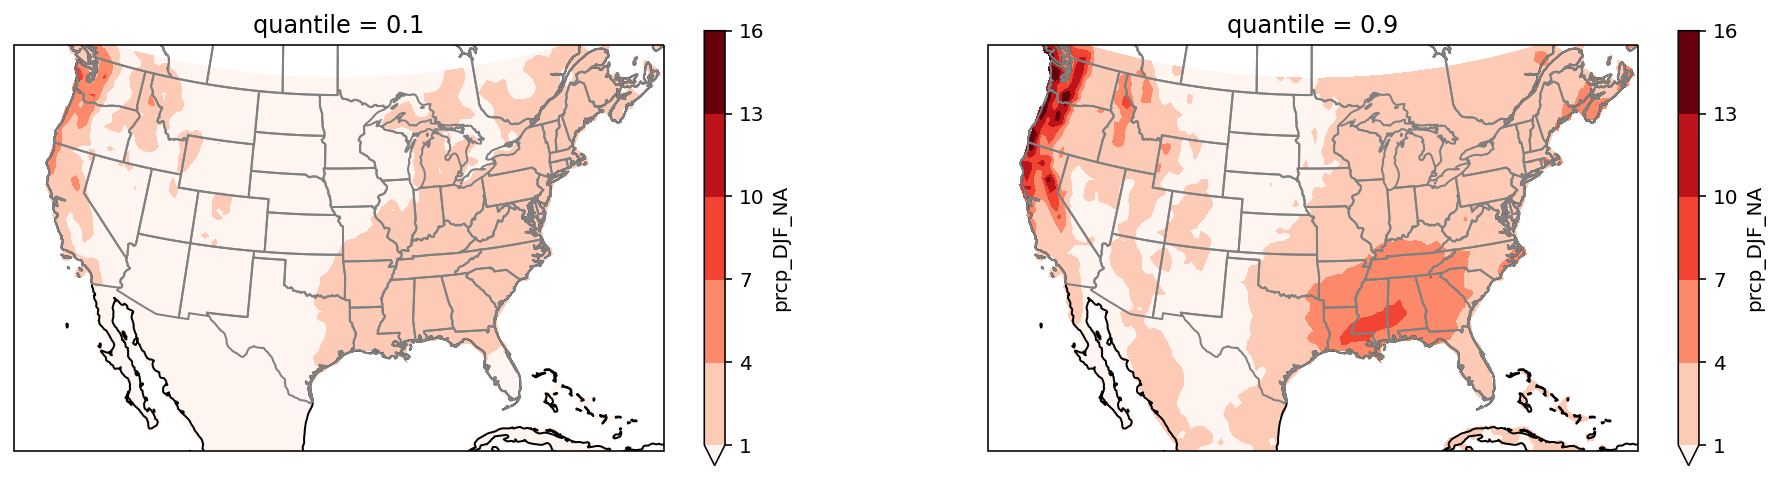

In [168]:

int80 = prcp[picks.values].quantile([0.1,0.9], dim = "T")


fig = plt.figure(figsize=(16,4))
axq = plt.subplot(1,2,1,projection=proj_map)
axr = plt.subplot(1,2,2,projection=proj_map)

int80[0].plot.contourf(transform=proj_dta, ax = axq, vmin=1, vmax=16, cmap='Reds', levels = 6)
axq.coastlines();
axq.add_feature(cfeature.STATES, edgecolor='gray')
axq.set_extent(extent)

int80[1].plot.contourf(transform=proj_dta, ax = axr, vmin=1, vmax=16, cmap='Reds', levels = 6)
axr.coastlines();
axr.add_feature(cfeature.STATES, edgecolor='gray')
axr.set_extent(extent)

In [169]:
cats = prcp.quantile([1./3.,2./3.], dim = "T")
lowMap = xr.DataArray()
lowNp = np.zeros(int80[0].shape) ; lowNp[np.isnan(int80[0])] = np.nan
medNp = np.zeros(int80[0].shape) ; lowNp[np.isnan(int80[0])] = np.nan
highNp = np.zeros(int80[0].shape) ; lowNp[np.isnan(int80[0])] = np.nan

In [170]:
#This block takes a very very long time to run.
for i in range(len(prcp[picks.values])):
    for j in range(len(prcp.Y)):
        for k in range(len(prcp.X)):
            if prcp[picks.values][i][j][k] < cats[0][j][k]:
                lowNp[j,k] += 0.1
            elif prcp[picks.values][i][j][k] > cats[0][j][k] and prcp[picks.values][i][j][k] < cats[1][j][k]:
                medNp[j,k] += 0.1
            elif prcp[picks.values][i][j][k] > cats[1][j][k]:
                highNp[j,k] += 0.1

Red indicates probability of lower tercile precipitation, and blue indicates middle tercile probability


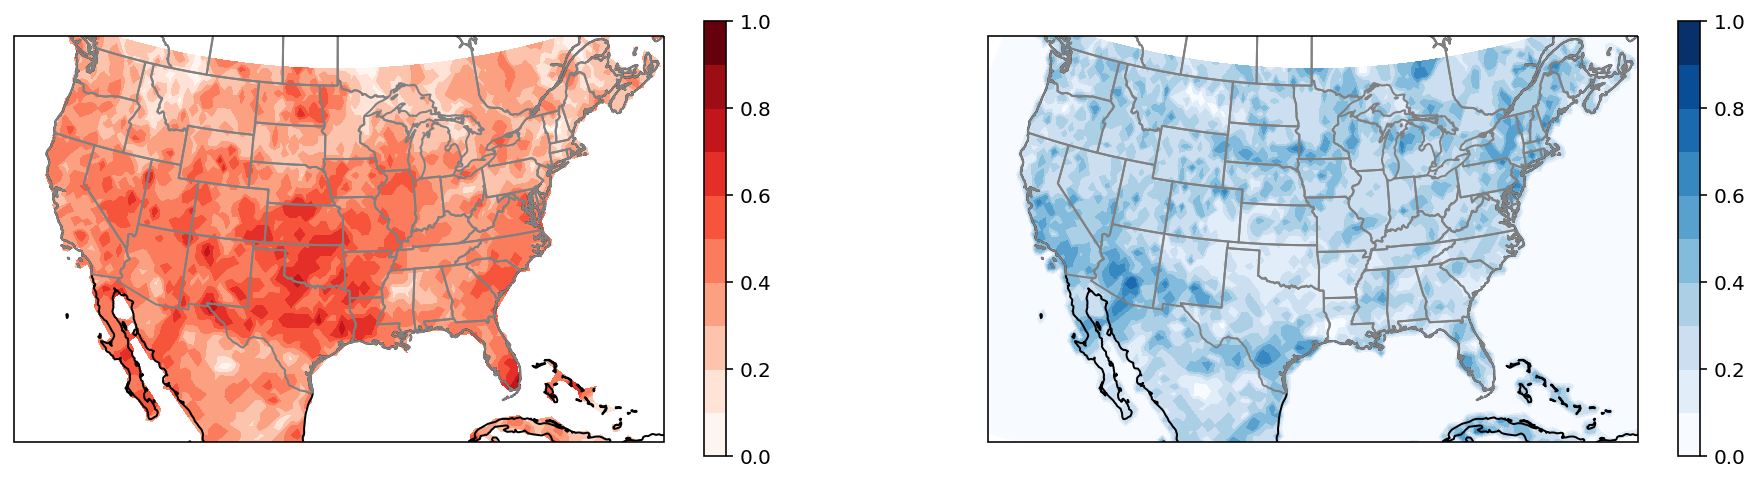

In [171]:
fig = plt.figure(figsize=(16,4))
axa = plt.subplot(1,2,1,projection=proj_map)
axb = plt.subplot(1,2,2,projection=proj_map)

lowArr = xr.DataArray(lowNp, coords = [int80[0].Y, int80[0].X])
medArr = xr.DataArray(medNp, coords = [int80[0].Y, int80[0].X])
highArr = xr.DataArray(highNp, coords = [int80[0].Y, int80[0].X])


lowArr.plot.contourf(transform=proj_dta, ax = axa, vmin=0, vmax=1, cmap='Reds', levels = 11)
axa.coastlines();
axa.add_feature(cfeature.STATES, edgecolor='gray')
axa.set_extent(extent)

medArr.plot.contourf(transform=proj_dta, ax = axb, vmin=0, vmax=1, cmap='Blues', levels = 11)
axb.coastlines();
axb.add_feature(cfeature.STATES, edgecolor='gray')
axb.set_extent(extent)


print("Red indicates probability of lower tercile precipitation, and blue indicates middle tercile probability")

Probability of upper tercile precipitation:


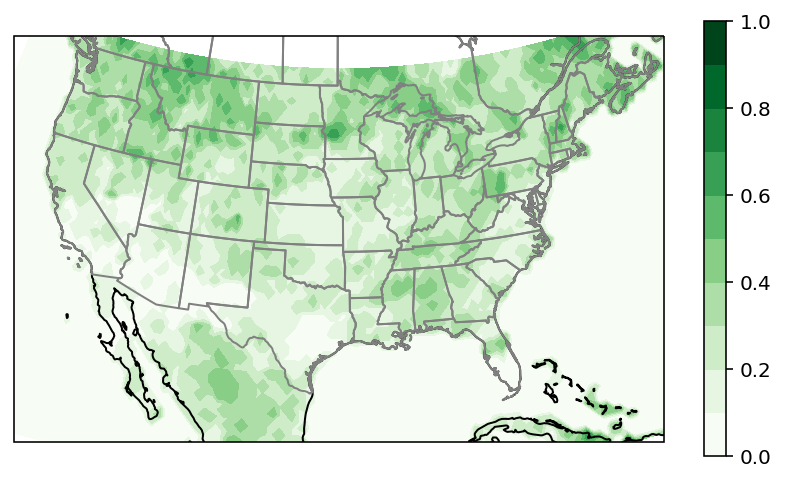

In [172]:
fig = plt.figure(figsize=(16,4))

axc = plt.subplot(1,2,1,projection=proj_map)
highArr.plot.contourf(transform=proj_dta, ax = axc, vmin=0, vmax=1, cmap='Greens', levels = 11)
axc.coastlines();
axc.add_feature(cfeature.STATES, edgecolor='gray')
axc.set_extent(extent)
print("Probability of upper tercile precipitation:")